CometLogger will be initialized in online mode
/home/monika/anaconda3/envs/ML/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352657443/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/monika/anaconda3/envs/ML/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:115: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | m

Training: 0it [00:00, ?it/s]

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.com/semjon/barf/09d29d66ba7f4a3292f88090e29fe0a6



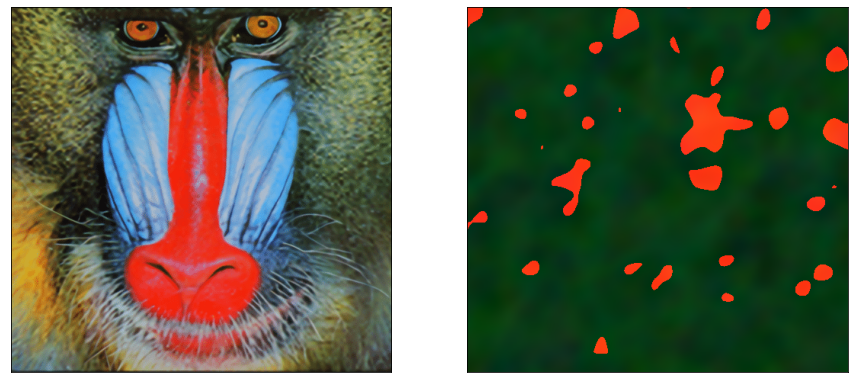

/home/monika/anaconda3/envs/ML/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:657: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [1]:
from pytorch_lightning.loggers import CometLogger

import torch
from torch import nn
import numpy as np
import torch.nn.functional as F
import pytorch_lightning as pl
from kornia.utils import create_meshgrid
from torch.utils.data import DataLoader, TensorDataset
from einops import rearrange
from torchvision.io import read_image
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from collections import OrderedDict
import cv2 as cv
from utils import show
from models import Homography, NeuralRenderer, SineLayer, Siren

class NeuralRendererPL(pl.LightningModule):
    def __init__(self, img_path, pos_enc=False, L=10, video_file = "output.avi"):
        super().__init__()
        #self.mlp = NeuralRenderer(True)
        
        self.L = L
        self.pos_enc = pos_enc
        if pos_enc:
            input_size = 2*2*L
        else:
            input_size = 2

        self.mlp = Siren(in_features=input_size, out_features=3, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)
        self.loss = nn.L1Loss()

        img = read_image(img_path, torchvision.io.ImageReadMode.RGB)/255.
        self.img = img

        C,H,W = img.size()
        
        self.out = cv.VideoWriter( video_file, cv.VideoWriter_fourcc('M','J','P','G'), 3, (W,H))

        img = rearrange(img,'c H W -> (H W) c')


        coords = create_meshgrid(H,W)
        self.coords = rearrange(coords,'b h w c -> (b h w) c')
        self.data  = TensorDataset(self.coords, img)
        self.dataloader = DataLoader(self.data, batch_size=H*W,pin_memory=True)

    def forward(self, x):

        if self.pos_enc:
            x = self.positional_encoding(x)

        return self.mlp(x)[0]

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000)
        return [optimizer], [lr_scheduler]

    def train_dataloader(self):
        return self.dataloader

    def val_dataloader(self):
        return self.dataloader

    def positional_encoding(self, input): # [B,...,N]
        L = self.L
        shape = input.shape
        freq = 2**torch.arange(L,dtype=torch.float32).to(input.device)*np.pi # [L]
        spectrum = input[...,None]*freq # [B,...,N,L]
        sin,cos = spectrum.sin(),spectrum.cos() # [B,...,N,L]
        input_enc = torch.stack([sin,cos],dim=-2) # [B,...,N,2,L]
        input_enc = input_enc.view(*shape[:-1],-1) # [B,...,2NL]
        # coarse-to-fine: smoothly mask positional encoding for BARF
        return input_enc

    def training_step(self, batch, batch_idx):
        x,y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        
        self.log('loss', loss.item())

        return loss

    def render_image(self):
        
        C,H,W = self.img.size()
        x = create_meshgrid(H,W).squeeze().to(self.device)
        x = rearrange(x,'H W C -> (H W) C')
        y = self(x)
        y = rearrange(y, '(H W) C -> C H W ', H=H,W=W)    
        return y

    def on_train_epoch_end(self):
        
        if self.current_epoch % 10 == 0:
            y = self.render_image()
            
            frame = rearrange(y, 'C H W -> H W C')    
            frame = frame.detach().cpu().numpy()
            frame = 255*frame
            frame = frame.astype(np.uint8)[:,:,::-1]
            self.out.write(frame)
            show([self.img,y])
            plt.show()

COMET_ML_PROJECT = "barf"
torch.cuda.empty_cache()
experiment_name = "BARF"
    

comet_logger = CometLogger(
    api_key="tMEjeyq5M7v1IPRCvS5fyGyuo",
    workspace="semjon", # Optional
    project_name= COMET_ML_PROJECT, # Optional
    # rest_api_key=os.environ["COMET_REST_KEY"], 
    #save_dir='./segmentation',
    experiment_name=experiment_name, # Optional,
    #display_summary_level = 0
)


model = NeuralRendererPL("baboon.png", pos_enc=False)
trainer = pl.Trainer(accelerator="gpu", logger=comet_logger,log_every_n_steps=1, max_epochs=1000)
trainer.fit(model)
model.out.release()